In [1]:
!nvidia-smi

Fri Mar 22 04:11:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   30C    P8               7W / 200W |      0MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print("Name:", device.name)
        print("Device type:", device.device_type)
else:
    print("No GPU devices found.")


Name: /physical_device:GPU:0
Device type: GPU


In [3]:
data_path = "job_intents.json"
     

In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import json
import pickle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\priks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\priks\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Text Preprocessing

In [5]:

words=[] #all unique words
classes = []  #all classed
documents = [] #all input with label
ignore_words = ['?', '!']

data_file = open(data_path, encoding='utf-8').read()
intents = json.loads(data_file)

In [6]:
intents['intents']

[{'tag': 'greeting',
  'patterns': ['Hi there',
   'How are you',
   'Is anyone there?',
   'Hey',
   'Hola',
   'Hello',
   'Good day',
   'Hey',
   'Ekse',
   'Hi'],
  'responses': ['Hi stranger',
   'Yebo yes, how can I help',
   'Ey watsupp',
   'Ekse Hoezit',
   'Hola',
   'Hey dude',
   'You again']},
 {'tag': 'goodbye',
  'patterns': ['Bye', 'See you later', 'Goodbye', 'Ok bye', 'Bye Bye'],
  'responses': ['See you!',
   'Have a nice day',
   'Sure Bye',
   'Later dude',
   'Sayoonara',
   'Peace out',
   'Sure dude',
   'Ciao']},
 {'tag': 'thanks',
  'patterns': ['Thanks',
   'Thank you',
   "That's helpful",
   'Awesome, thanks',
   'Thanks for helping me'],
  'responses': ['Happy to help!',
   'Any time!',
   'My pleasure',
   'You are welcome',
   'Sure dude']},
 {'tag': 'noanswer',
  'patterns': [],
  'responses': ["Sorry, can't understand you",
   'Please give me more info',
   'Not sure I understand',
   'I am still here dude']},
 {'tag': 'name',
  'patterns': ['What is y

In [7]:

for intent in intents['intents']:
    for pattern in intent['patterns']:

        w = nltk.word_tokenize(pattern)
        words.extend(w)

        documents.append((w, intent['tag']))


        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [8]:
documents

[(['Hi', 'there'], 'greeting'),
 (['How', 'are', 'you'], 'greeting'),
 (['Is', 'anyone', 'there', '?'], 'greeting'),
 (['Hey'], 'greeting'),
 (['Hola'], 'greeting'),
 (['Hello'], 'greeting'),
 (['Good', 'day'], 'greeting'),
 (['Hey'], 'greeting'),
 (['Ekse'], 'greeting'),
 (['Hi'], 'greeting'),
 (['Bye'], 'goodbye'),
 (['See', 'you', 'later'], 'goodbye'),
 (['Goodbye'], 'goodbye'),
 (['Ok', 'bye'], 'goodbye'),
 (['Bye', 'Bye'], 'goodbye'),
 (['Thanks'], 'thanks'),
 (['Thank', 'you'], 'thanks'),
 (['That', "'s", 'helpful'], 'thanks'),
 (['Awesome', ',', 'thanks'], 'thanks'),
 (['Thanks', 'for', 'helping', 'me'], 'thanks'),
 (['What', 'is', 'your', 'name'], 'name'),
 (['Whats', 'your', 'name'], 'name'),
 (['Tell', 'me', 'your', 'name'], 'name'),
 (['Who', 'are', 'you'], 'name'),
 (['Ungubani'], 'name'),
 (['Tell', 'me', 'about', 'yourself'], 'name'),
 (['You', 'are'], 'name'),
 (['What', 'do', 'you', 'do'], 'options'),
 (['How', 'can', 'you', 'help'], 'options'),
 (['What', 'do', 'you', 

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
lm_words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]

In [11]:
print(words, "\n", lm_words)

['Hi', 'there', 'How', 'are', 'you', 'Is', 'anyone', 'there', '?', 'Hey', 'Hola', 'Hello', 'Good', 'day', 'Hey', 'Ekse', 'Hi', 'Bye', 'See', 'you', 'later', 'Goodbye', 'Ok', 'bye', 'Bye', 'Bye', 'Thanks', 'Thank', 'you', 'That', "'s", 'helpful', 'Awesome', ',', 'thanks', 'Thanks', 'for', 'helping', 'me', 'What', 'is', 'your', 'name', 'Whats', 'your', 'name', 'Tell', 'me', 'your', 'name', 'Who', 'are', 'you', 'Ungubani', 'Tell', 'me', 'about', 'yourself', 'You', 'are', 'What', 'do', 'you', 'do', 'How', 'can', 'you', 'help', 'What', 'do', 'you', 'know', 'What', 'is', 'your', 'purpose', 'How', 'can', 'you', 'help', 'South', 'Africa', 'What', 'can', 'you', 'tell', 'me', 'about', 'SA', 'SA', 'Tell', 'me', 'about', 'SA', 'What', 'about', 'SA', 'What', 'do', 'you', 'know', 'about', 'SA', 'Tell', 'me', 'more', 'about', 'SA', 'What', 'can', 'you', 'tell', 'me', 'about', 'South', 'Africa', 'Tell', 'me', 'about', 'South', 'Africa', 'What', 'about', 'South', 'Africa', 'What', 'do', 'you', 'know', 

In [12]:

lm_words = sorted(list(set(lm_words)))
lm_words

["'s",
 ',',
 'about',
 'africa',
 'anyone',
 'are',
 'awesome',
 'bye',
 'can',
 'day',
 'do',
 'ekse',
 'fact',
 'for',
 'give',
 'good',
 'goodbye',
 'hello',
 'help',
 'helpful',
 'helping',
 'hey',
 'hi',
 'hola',
 'how',
 'interesting',
 'is',
 'know',
 'later',
 'me',
 'more',
 'name',
 'ok',
 'purpose',
 'sa',
 'see',
 'some',
 'something',
 'south',
 'tell',
 'thank',
 'thanks',
 'that',
 'there',
 'ungubani',
 'what',
 'whats',
 'who',
 'you',
 'your',
 'yourself']

In [13]:
classes = sorted(list(set(classes)))

print (len(documents), "documents")
print (len(classes), "classes", classes)
print (len(lm_words), "unique lemmatized words", lm_words)

53 documents
7 classes ['goodbye', 'greeting', 'name', 'options', 'south_africa_facts', 'south_africa_info', 'thanks']
51 unique lemmatized words ["'s", ',', 'about', 'africa', 'anyone', 'are', 'awesome', 'bye', 'can', 'day', 'do', 'ekse', 'fact', 'for', 'give', 'good', 'goodbye', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'hola', 'how', 'interesting', 'is', 'know', 'later', 'me', 'more', 'name', 'ok', 'purpose', 'sa', 'see', 'some', 'something', 'south', 'tell', 'thank', 'thanks', 'that', 'there', 'ungubani', 'what', 'whats', 'who', 'you', 'your', 'yourself']


In [14]:

pickle.dump(lm_words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

## Feature Engineering / Text representation

In [15]:
import keras
print(keras.__version__)


2.10.0


In [16]:

# initializing training data
training = []
output_empty = [0] * len(classes)

In [17]:
for doc in documents:

    bag = []

    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in lm_words:
        bag.append(1) if w in pattern_words else bag.append(0)


    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

In [18]:
def list_shape(lst):
    if isinstance(lst, list):
        # Get the length of the list (dimension along the first axis)
        shape = [len(lst)]
        # Recursively get the shape of the first element
        if lst:
            shape.extend(list_shape(lst[0]))
    else:
        # Base case: if not a list, return an empty list
        return []
    return shape

shape = list_shape(training)


shape

[53, 2, 51]

In [20]:
import numpy as np
import random

# Flatten the list of lists into a list of tuples
flattened_training = [(input_data, output_data) for input_data, output_data in training]

# Shuffle the flattened list
random.shuffle(flattened_training)

# Convert the shuffled flattened list to a NumPy array
training_array = np.array(flattened_training, dtype=object)


In [22]:
training_array.shape

(53, 2)

In [24]:
# create train and test lists. X - patterns, Y - intents
train_x = list(training_array[:,0])
train_y = list(training_array[:,1])

VALIDATION_SET = (train_x, train_y)
     

In [25]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
     

In [26]:

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [27]:
#fitting and saving the model
history = model.fit(np.array(train_x), np.array(train_y), epochs=250, validation_data = VALIDATION_SET, batch_size=5, verbose=1)
     

Epoch 1/250
11/11 [==============================] - 1s 19ms/step - loss: 1.9555 - accuracy: 0.1698 - val_loss: 1.9036 - val_accuracy: 0.2830
Epoch 2/250
11/11 [==============================] - 0s 7ms/step - loss: 1.8869 - accuracy: 0.2264 - val_loss: 1.7958 - val_accuracy: 0.5094
Epoch 3/250
11/11 [==============================] - 0s 6ms/step - loss: 1.7703 - accuracy: 0.3396 - val_loss: 1.6879 - val_accuracy: 0.5094
Epoch 4/250
11/11 [==============================] - 0s 8ms/step - loss: 1.7101 - accuracy: 0.3208 - val_loss: 1.5673 - val_accuracy: 0.4528
Epoch 5/250
11/11 [==============================] - 0s 6ms/step - loss: 1.5780 - accuracy: 0.4528 - val_loss: 1.4387 - val_accuracy: 0.5660
Epoch 6/250
11/11 [==============================] - 0s 6ms/step - loss: 1.4169 - accuracy: 0.5094 - val_loss: 1.2835 - val_accuracy: 0.6792
Epoch 7/250
11/11 [==============================] - 0s 6ms/step - loss: 1.5645 - accuracy: 0.4340 - val_loss: 1.1603 - val_accuracy: 0.7358
Epoch 8/250


<Axes: >

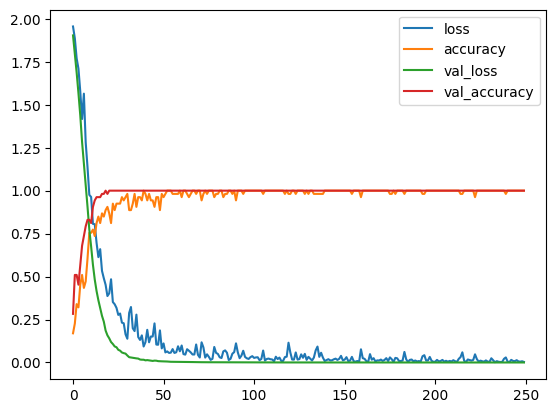

In [28]:
pd.DataFrame(history.history).plot()

In [29]:

model.save('chatbot_model.h5', history)
print("model Saved")

model Saved


In [30]:
import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
import pickle
import numpy as np

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

model = tf.keras.models.load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('job_intents.json', encoding='utf-8').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

lemmatizer = WordNetLemmatizer()

def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))


def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list


def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
        else:
            result = "You must ask the right questions"
    return result

    

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\priks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\priks\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:

user_message = "Hello, how can I help you?"

# Get the chatbot response
response = chatbot_response(user_message)

# Print the response
print(response)


1/1 [==============================] - 0s 12ms/step
I can tell you about South Africa
